In [8]:

import os
import gc
import numpy as np  
import scanpy as sc
import pandas as pd

from conformalSC_annotator import  ConformalSCAnnotator
from torchcp.classification.score import  APS


query_data_path = 'test_data\GSE178360\GSE178360_immune.h5ad'
adata_query = sc.read_h5ad(query_data_path) 

## This is te expected input data: ##

X = adata_query.X.astype(np.float32)                        # data matrix (cells x genes)
var_query_list = adata_query.var["features"].tolist()       # This is the case of the list
#var_query_df = pd.DataFrame({'features':var_query_list })  # Unncomment for testing. This is the case of the df
obs_query = adata_query.obs                                 # not needed, for ground thruth test

     


In [ ]:


annotator = ConformalSCAnnotator(X, var_query_list, obs_query) # obs_query is optional, it will be used for annotate the predicted cells. 

annotator.quality_control()  ## This is an optional step to do a basic preprocess the data. If the data is already preprocessed, this step is optional.

# Define que network architecture   
network_architecture:dict = {   
            "hidden_sizes": [128, 128, 64, 64],
            "dropout_rates": [0.4, 0.3, 0.4, 0.25],
            "learning_rate": 0.0001}

OOD_detector_config = {
            "n_estimators": 200,
            "max_features": 1,
            "alpha": 0.05}
    

reference_data_path = os.path.join("models", "HumanLung_TopMarkersFC_level3.h5ad")     # Path to the reference data

annotator.configure(reference_path = reference_data_path,
                    model_architecture = network_architecture,   # Optional, if not provided, default values will be used
                    OOD_detector = OOD_detector_config,          # Optional, if not provided, default values will be used
                    CP_predictor = "cluster",                    # mondrian or cluster
                    cell_type_level = "celltype_level3",         # class name for fitting the model.  
                    cell_types_excluded_treshold = 50,           # Exclude cell types with less than 50 cells
                    test = True,                                 # Perform internal test of the model
                    alpha = [0.01, 0.05, 0.1],                   # Confidence of the predictions
                    non_conformity_function = APS(),             # NC-function provided by or compatible with torchCP    
                    epoch=20,
                    batch_size = 525)  
    

# annotate your data to a given significance level
annotator.annotate(batch_correction="combat")  # batch_correction = "combat" or "harmony" or "mnn" or False



Succesfully generated object:  (9468, 30555)
Filtering low quality cells...
Filtered! Post-QC shape:  (9468, 30555)
Model not trained yet. Fitting the model first.
Loading reference data...
Reference data loaded.
Detecting common genes...
Common genes detected: 1140
Running integration....


In [3]:
# Get the predictions returning the observations of the query data object
print("\nPredicted annotations sets: \n" , annotator.adata_query.obs)

    
ground_truth_labels_list = obs_query["cell_type"].tolist()
annotator.recover_original_cells( ground_truth_labels_list, similarity_threshold=70)


y_true = annotator._mapped_original_ground_truth_labels ## Ground thruth labels mapped to the model labels (predictions)
#annotator._mapping


results = []
for pred,cp_pred_001,cp_pred_005, cp_pred_010, true, o_g_t in zip(
        annotator.adata_query.obs["predicted_labels"],
        annotator.adata_query.obs["prediction_sets_0.01"],
        annotator.adata_query.obs["prediction_sets_0.05"],
        annotator.adata_query.obs["prediction_sets_0.1"],
        y_true,
         ground_truth_labels_list):
        
    print(f"Predicted: {pred} - CP 0.01: {cp_pred_001} - CP 0.05: {cp_pred_005} - CP 0.10: {cp_pred_010} - True: {true}. original cell Subt: {o_g_t}")
        
    results.append({
        "Predicted": pred,
        "CP 0.01": cp_pred_001,
        "CP 0.05": cp_pred_005,
        "CP 0.1": cp_pred_010,
        "True": true,
        "Original_Cell_Subtype": o_g_t
    })
    
df_results = pd.DataFrame(results)
df_results.to_csv("saves/results_immune.csv", index=False)  # Save to CSV if needed


Predicted annotations sets: 
                                orig.ident    nCount_RNA  nFeature_RNA  \
AAACCCAAGCCTCTGG-1_1-query  SeuratProject  16767.370165          4221   
AAACCCAAGTCAAGCG-1_1-query  SeuratProject   4690.669529          1761   
AAACCCACACTGTTCC-1_1-query  SeuratProject   4061.650062          1830   
AAACGCTAGTACCCTA-1_1-query  SeuratProject   4045.692015          1351   
AAACGCTTCCCGAATA-1_1-query  SeuratProject  36168.795726          2745   
...                                   ...           ...           ...   
GTGGAAGTCCATAGAC-1_3-query  SeuratProject   3537.660464          1564   
TACTTCAGTAATTGGA-1_3-query  SeuratProject   2172.917685          1063   
TCATGCCGTGGTCCCA-1_3-query  SeuratProject   2792.173999          1405   
TGACGCGGTCGAATTC-1_3-query  SeuratProject   4764.288856          1625   
TTTACCATCATTCACT-1_3-query  SeuratProject   3499.206924          1255   

                            nCount_SCT  nFeature_SCT  S.Score  G2M.Score  \
AAACCCAAGCCTCTGG

In [4]:
df_results.head(10)

Predicted                                            CP 0.01  \
0       OOD                                              [OOD]   
1       AT2  [AEC, AF1, AF2, AM, ASMC, AT1, AT2, B, CAP1, C...   
2        NK  [AEC, AF2, AM, ASMC, AT1, AT2, B, CAP1, CAP2, ...   
3     CD4_T  [AEC, AF2, AM, ASMC, AT1, AT2, B, Basal, CAP1,...   
4       OOD                                              [OOD]   
5     CD4_T  [AEC, ASMC, AT1, AT2, B, CAP1, CD4_T, CD8_T, C...   
6        IM          [AM, B, Ciliated, IM, Plasma, cDC2, iMON]   
7        NK  [AEC, AF2, AM, AT1, AT2, CAP2, CD4_T, CD8_T, G...   
8      pMON                                             [pMON]   
9      iMON                     [AF2, AM, IM, LEC, iMON, pMON]   

                                             CP 0.05  \
0                                              [OOD]   
1  [AEC, AF1, AF2, AM, AT1, AT2, CAP1, CAP2, CD4_...   
2  [AEC, AM, AT1, AT2, CAP2, CD4_T, CD8_T, Goblet...   
3  [AM, ASMC, AT1, Basal, CAP1, CAP2, CD4_T, Deut...   
4                                              [OOD]   
5  [AEC, AT1, AT2, CAP1, CD4_T, CD8_T, Deuterosom...   
6                                         [IM, cDC2]   
7  [AT2, CAP2, CD8_T, NK, Neutrophil, Secretory, ...   
8                                             [pMON]   
9                                             [iMON]   

                                              CP 0.1    True  \
0                                              [OOD]     OOD   
1  [AEC, AF1, AM, AT1, AT2, CAP1, CAP2, CD8_T, Io...   CD8_T   
2  [AEC, AT2, CAP2, CD4_T, CD8_T, NK, Pericyte, S...     OOD   
3  [ASMC, CAP1, CD4_T, Ionocyte, Mesothelial, Pla...   CD4_T   
4                                              [OOD]  Plasma   
5  [AT1, AT2, CAP1, CD4_T, Deuterosomal, Ionocyte...   CD4_T   
6                                         [IM, cDC2]     OOD   
7                                        [CD8_T, NK]     OOD   
8                                             [pMON]     OOD   
9                                             [iMON]     OOD   

   Original_Cell_Subtype  
0              Dendritic  
1                 CD8+ T  
2         Natural Killer  
3                 CD4+ T  
4                 Plasma  
5                 CD4+ T  
6              Dendritic  
7         Natural Killer  
8  Nonclassical Monocyte  
9     Classical Monocyte

In [5]:
df_results['Original_Cell_Subtype'].value_counts()

Original_Cell_Subtype
Natural Killer           1984
Nonclassical Monocyte    1414
CD4+ T                   1360
Classical Monocyte       1102
CD8+ T                   1024
Dendritic                 878
Basophil/Mast             522
Macrophage                448
B                         351
Plasma                    146
Proliferating NK/T         78
Proliferating Immune       67
Neutrophil                 53
Platelet                   41
Name: count, dtype: int64

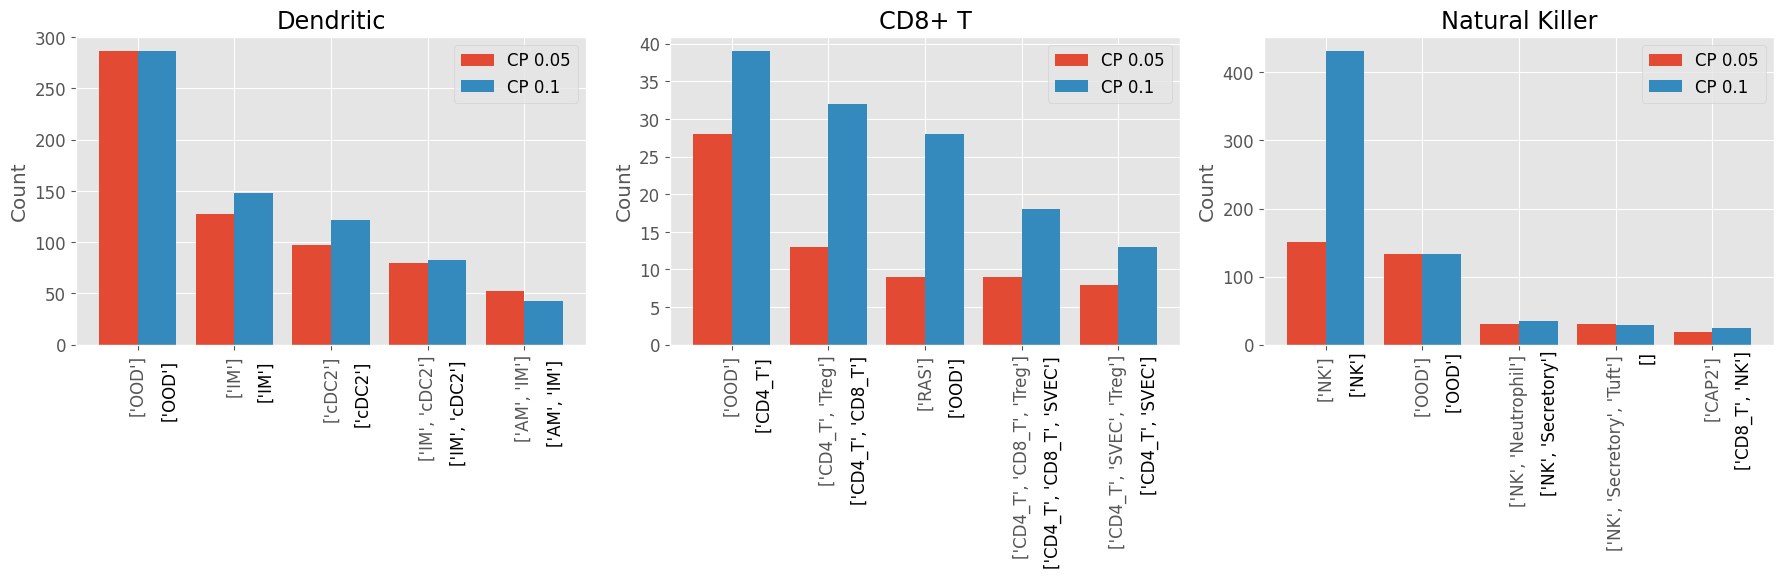

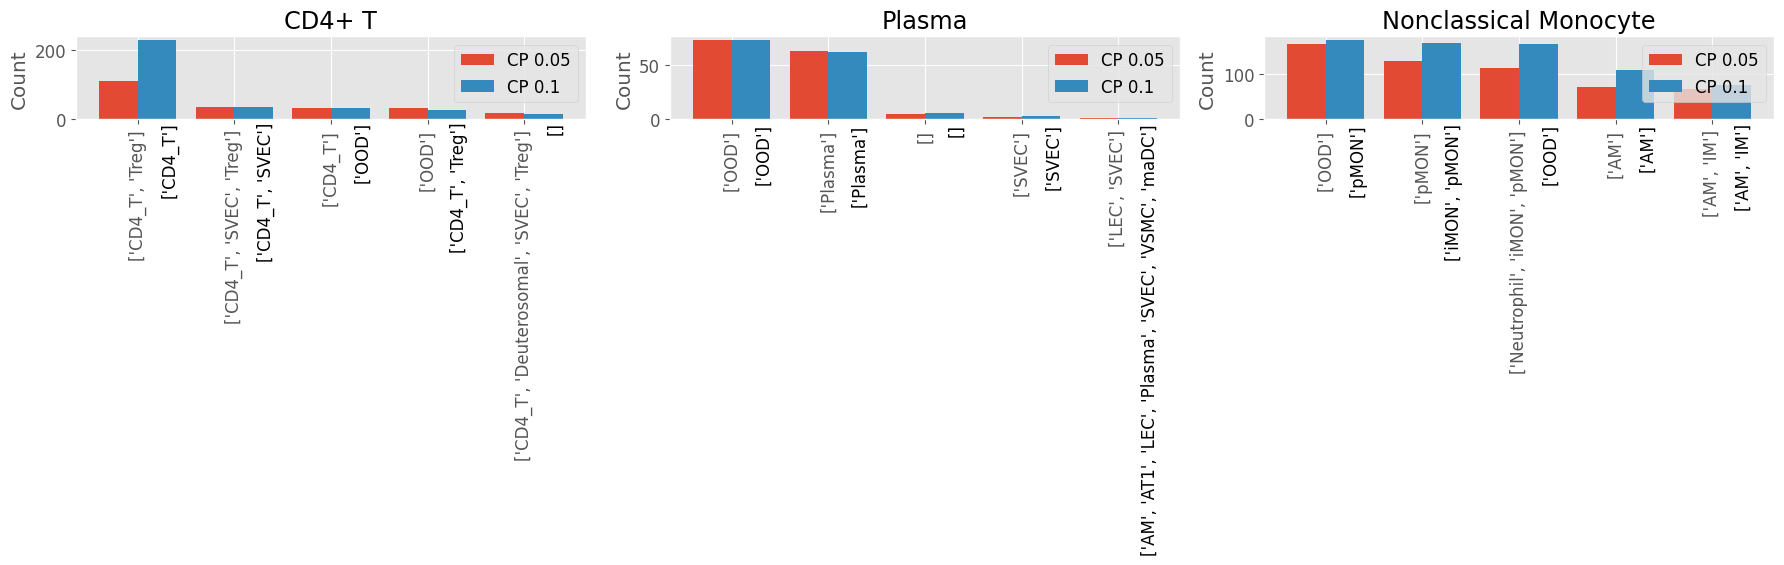

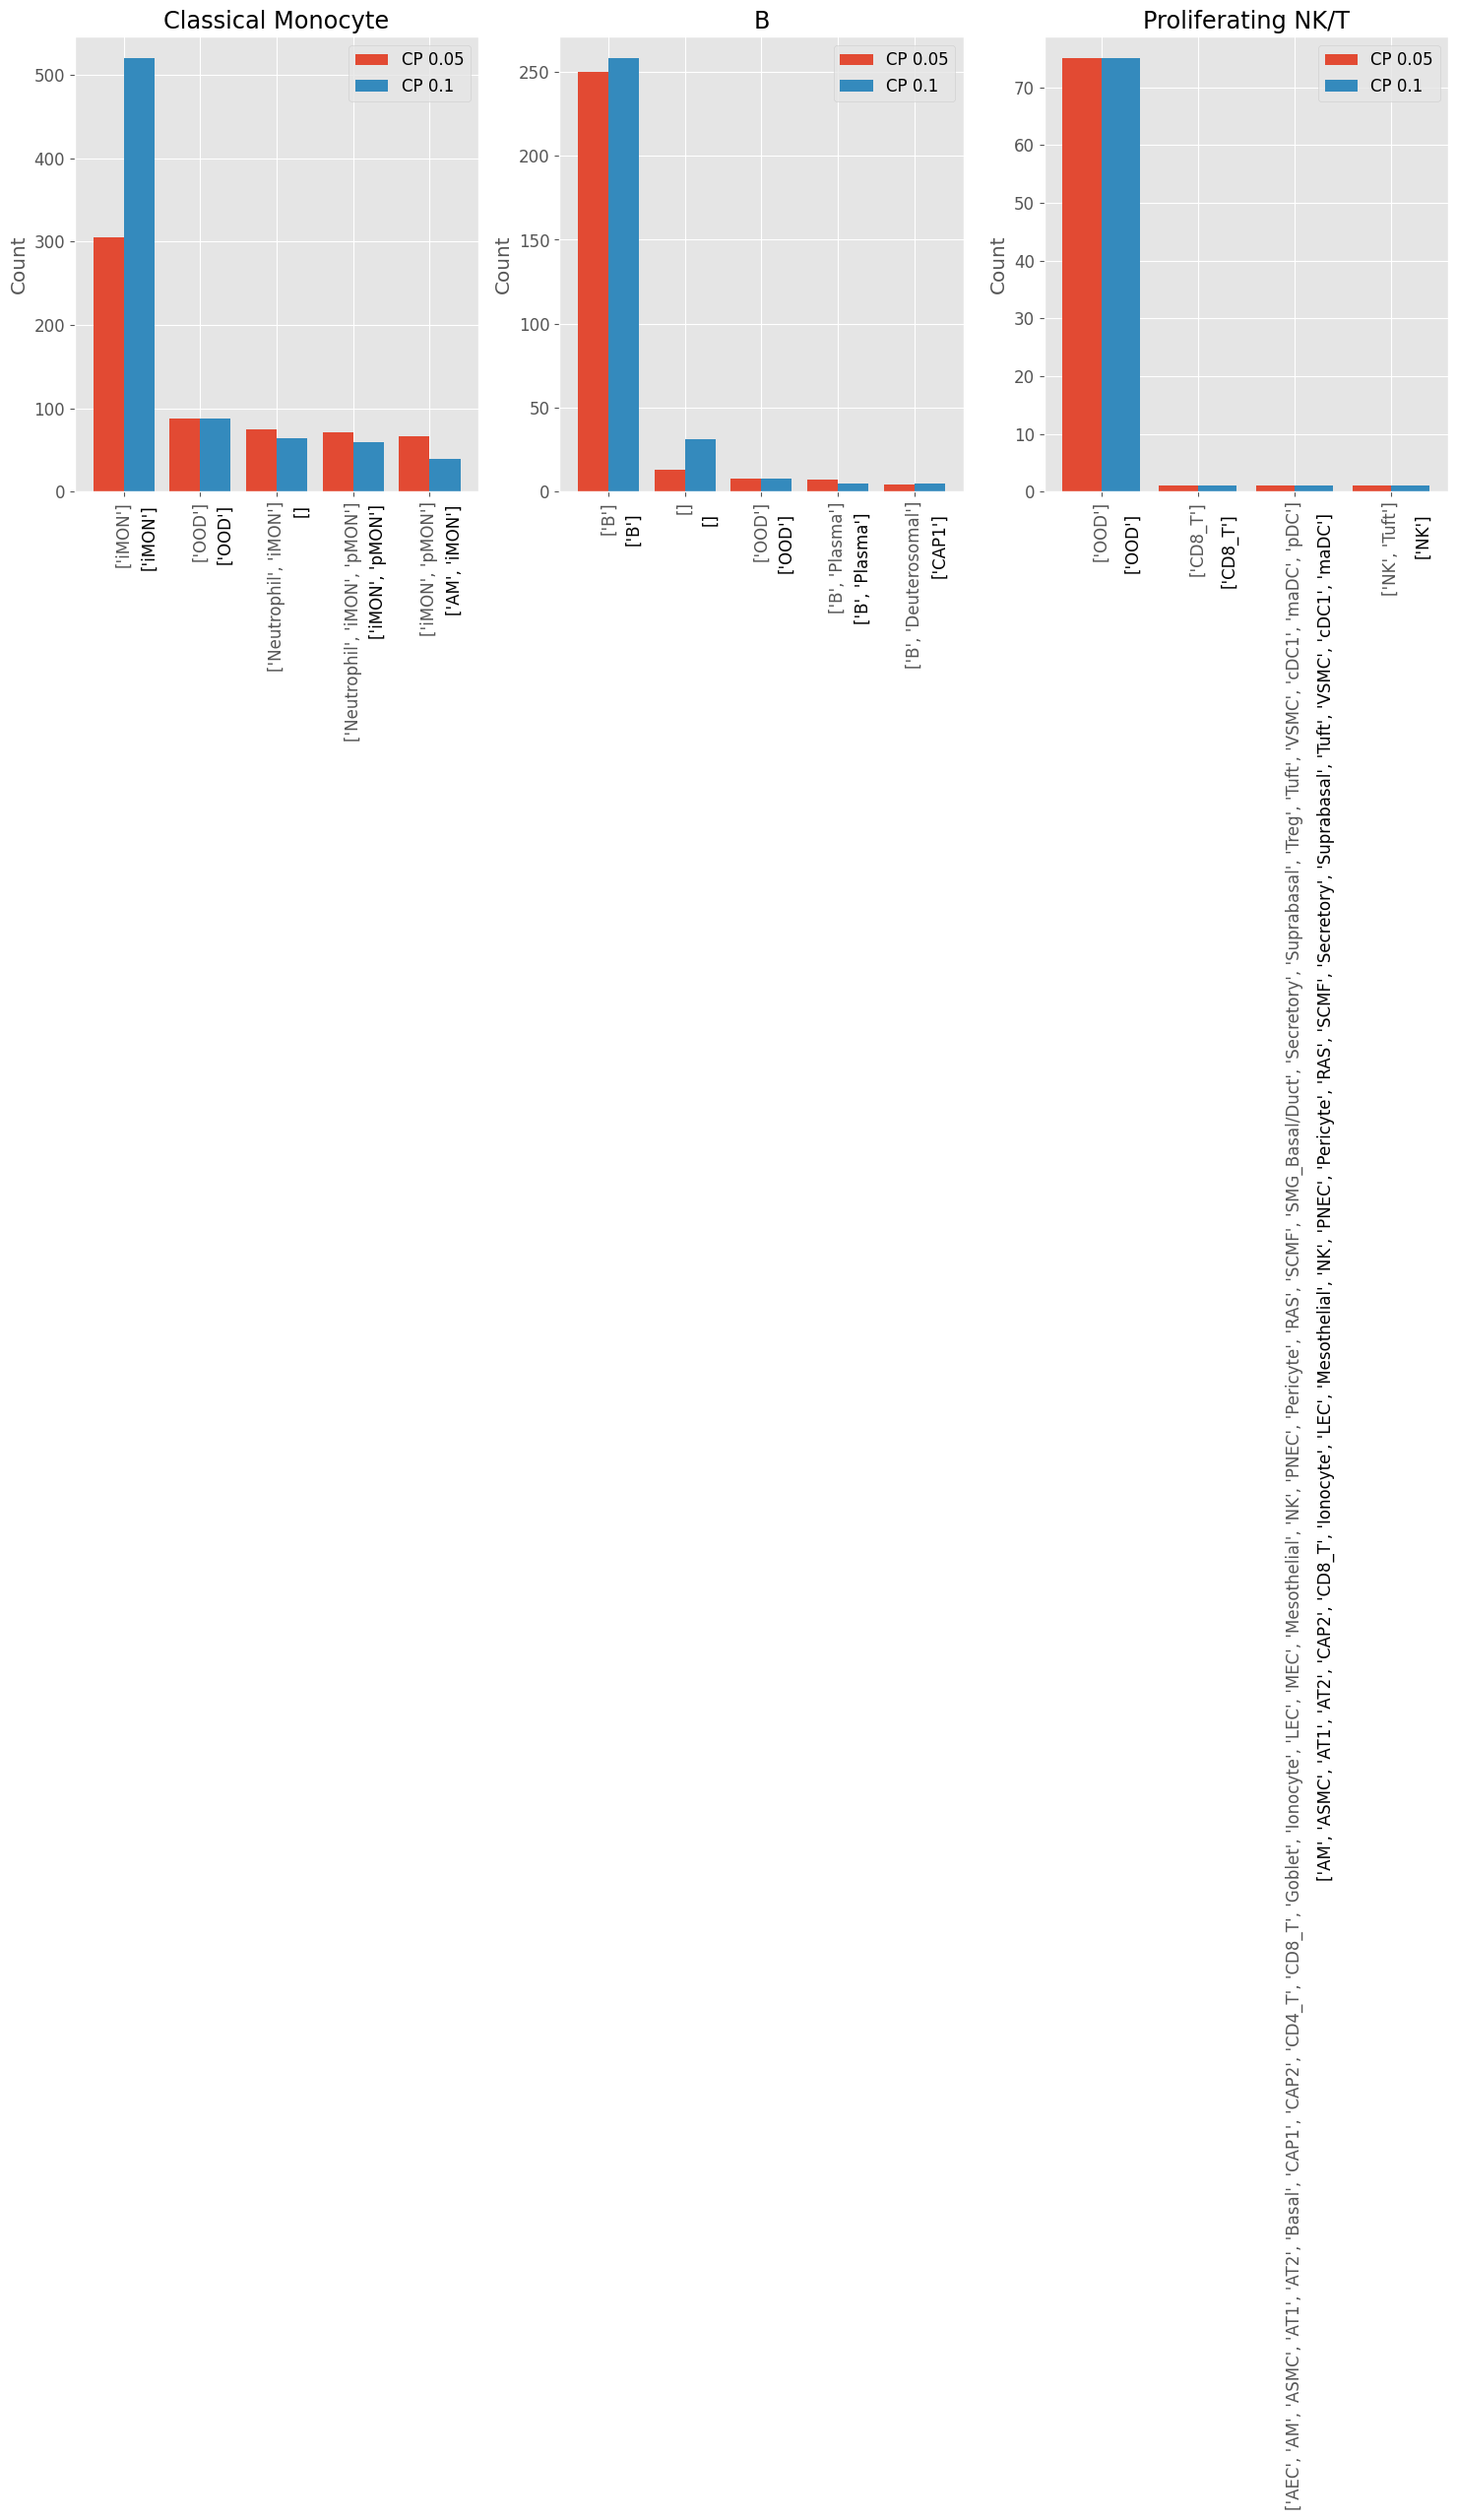

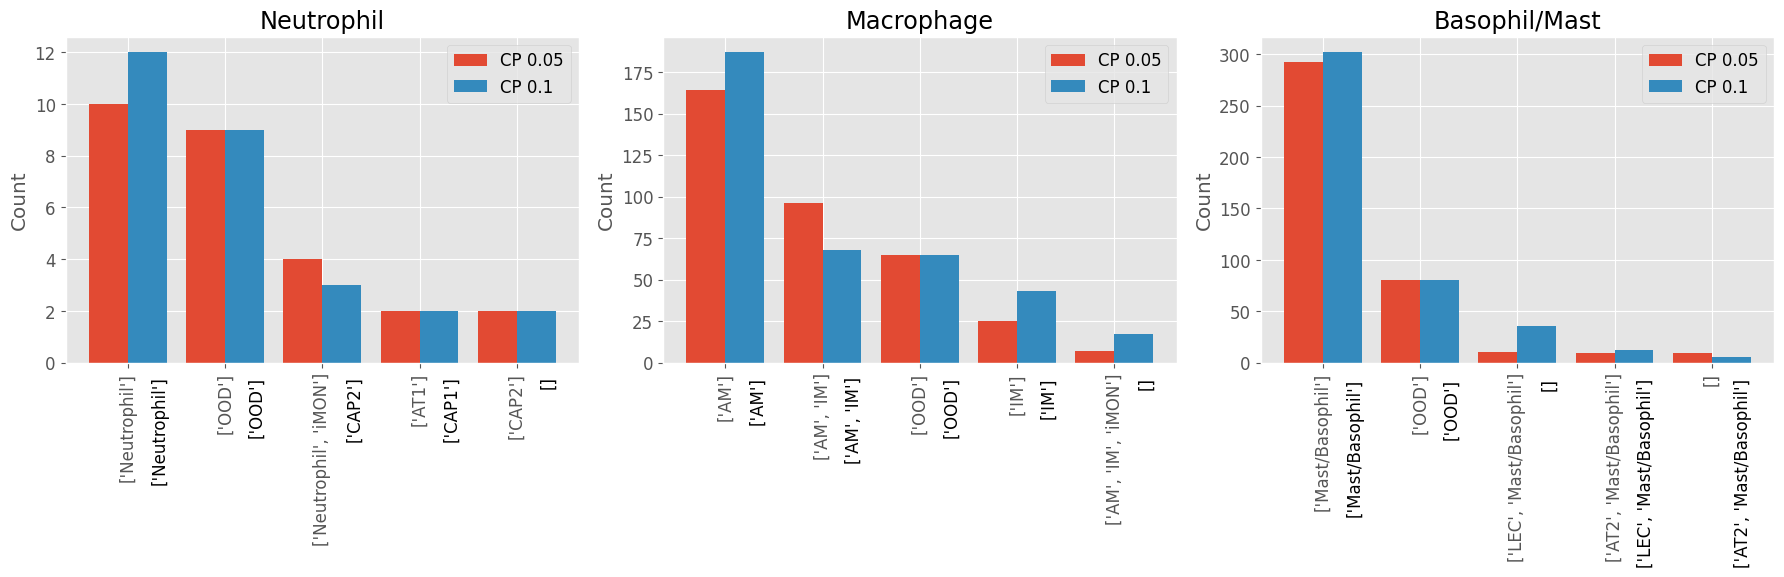

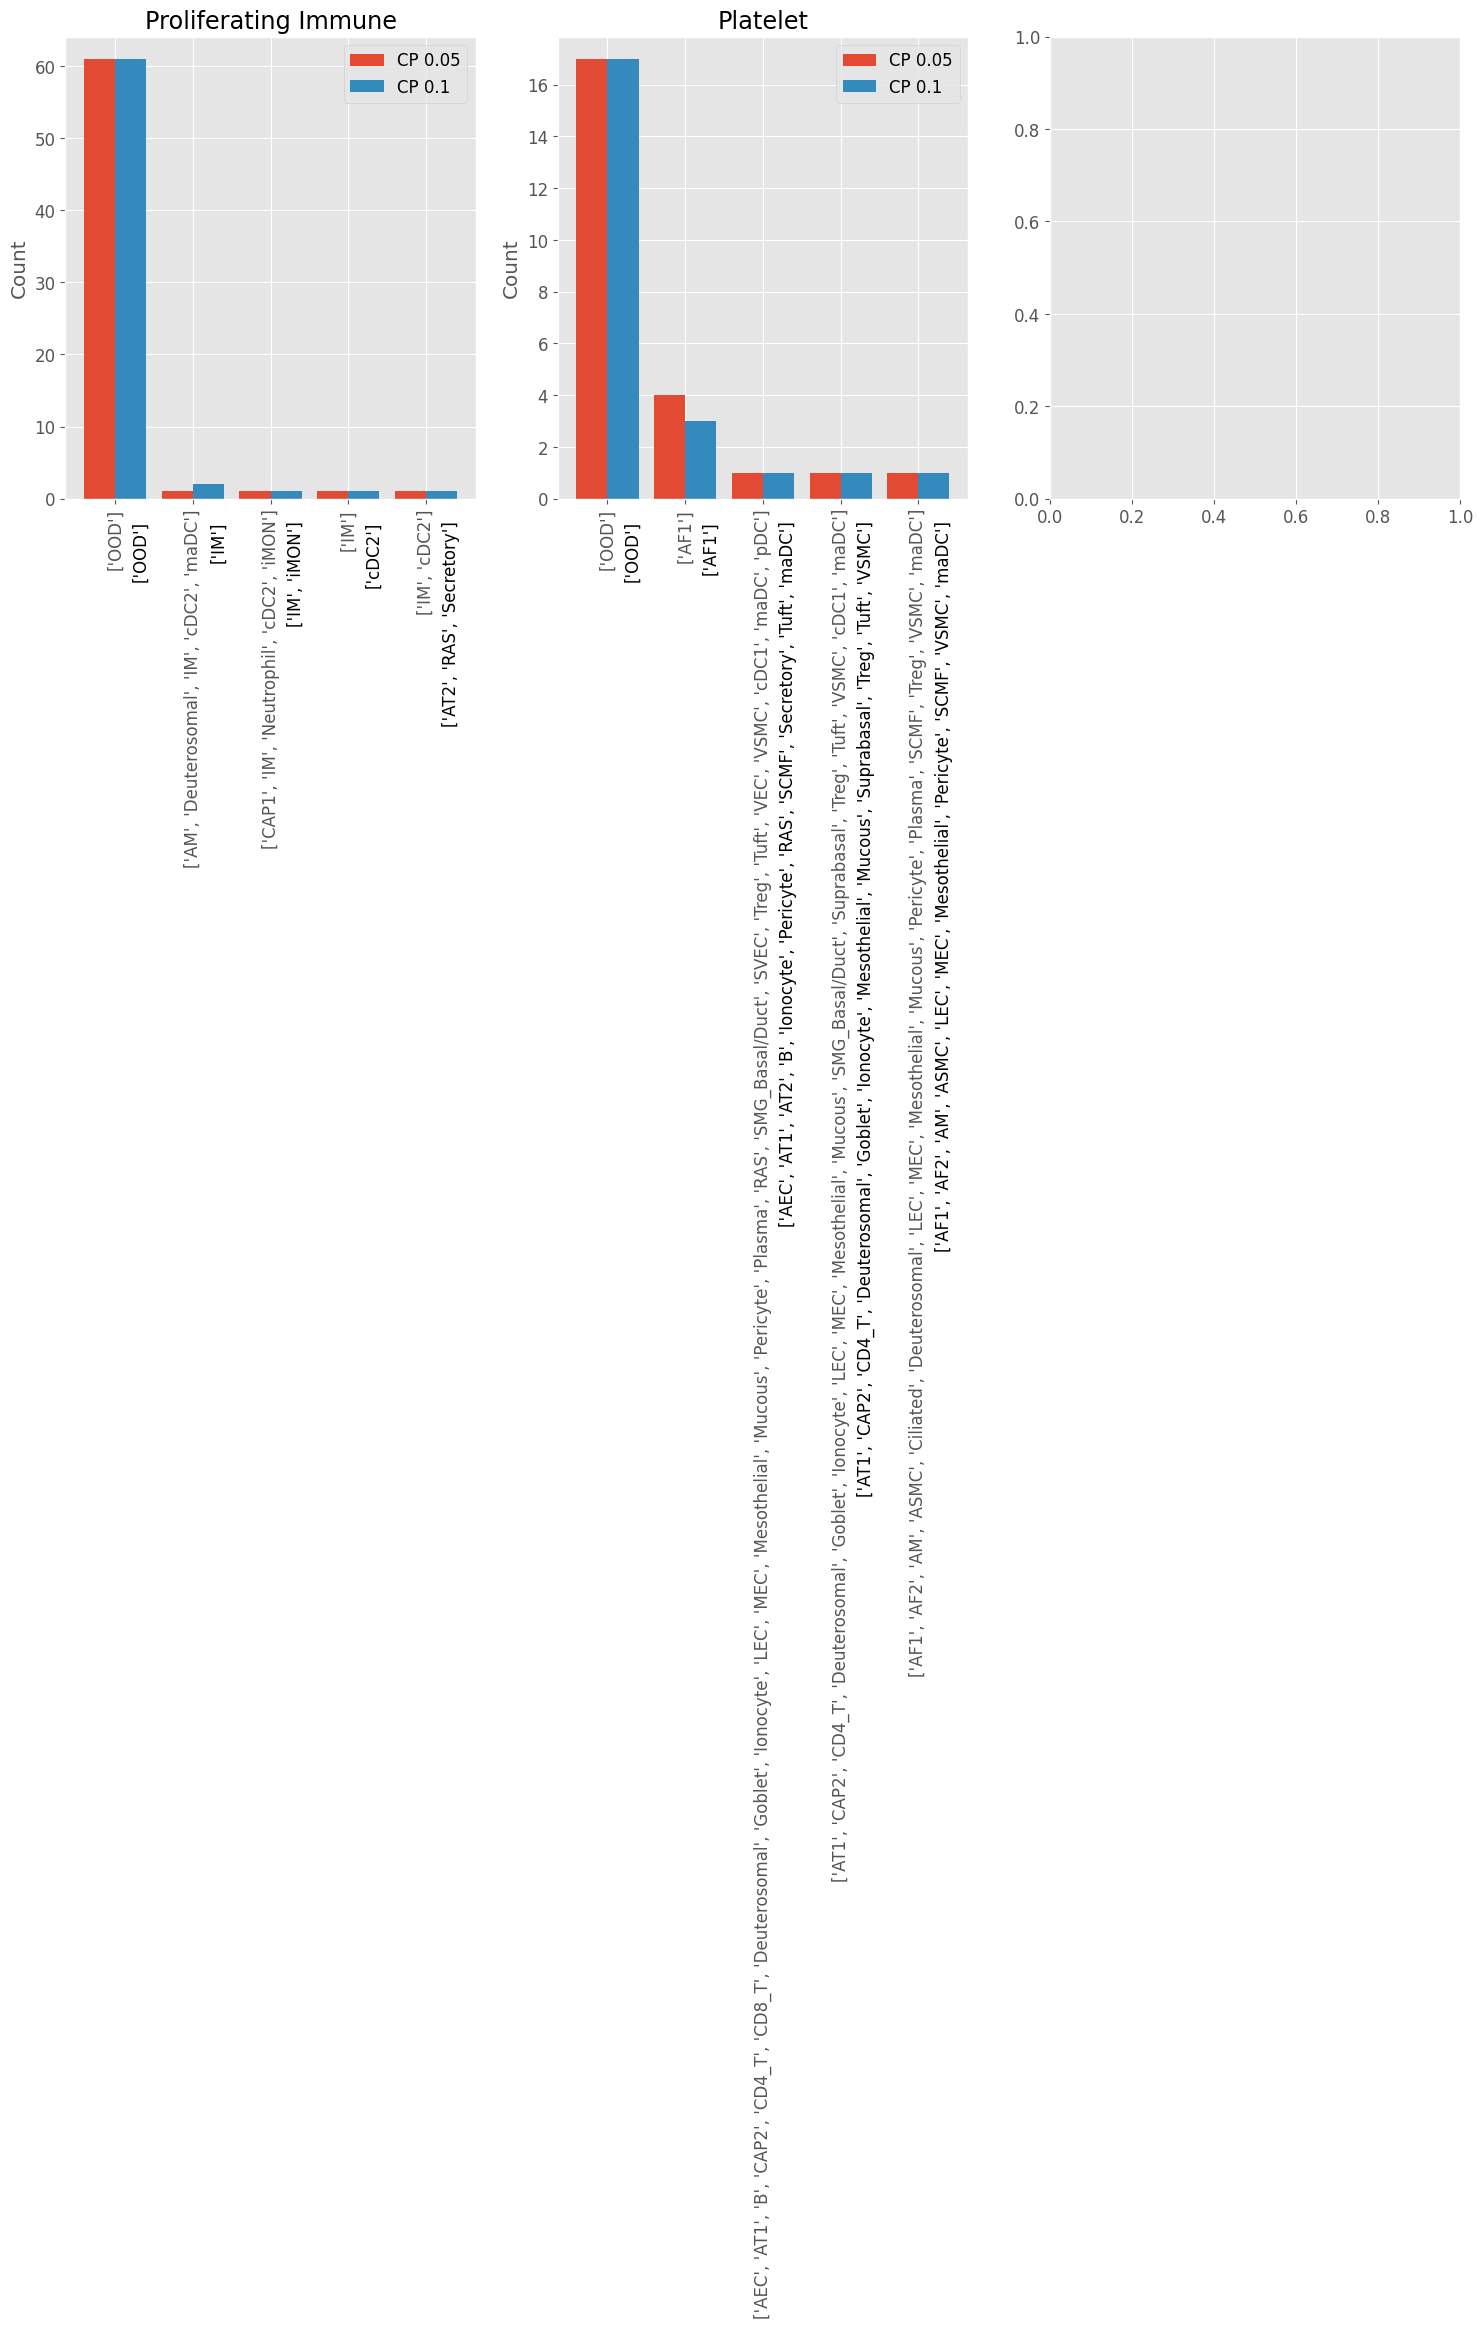

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set a scientific style for the plots
plt.style.use('ggplot')
rcParams.update({'font.size': 12, 'figure.figsize': (18, 6)})

unique_cells = df_results['Original_Cell_Subtype'].unique()

# Create blocks of 3
block_size = 3
for i in range(0, len(unique_cells), block_size):
    fig, axes = plt.subplots(1, block_size, figsize=(18, 6))
    for j, cell in enumerate(unique_cells[i:i + block_size]):
        ax = axes[j] if block_size > 1 else axes
        df_ = df_results[df_results['Original_Cell_Subtype'] == cell]

        # Get the top 5 value counts for both columns
        value_counts_05 = df_["CP 0.05"].astype(str).value_counts().head(5)
        value_counts_1 = df_["CP 0.1"].astype(str).value_counts().head(5)
        

        value_counts_05_names = value_counts_05.index
        value_counts_1_names = value_counts_1.index


        # Create the bar width and positions
        x = np.arange(len(value_counts_05))
        bar_width = 0.4

        # Plot the bars for CP 0.05 and CP 0.1
        bars_05 = ax.bar(x - bar_width / 2, value_counts_05, bar_width, label='CP 0.05')
        
        bars_1 = ax.bar(x + bar_width / 2, value_counts_1, bar_width, label='CP 0.1')

        # Add labels, title, and legend
        ax.set_title(cell)
        ax.set_ylabel('Count')
        
        ax.set_xticks(x)
        ax.set_xticklabels(value_counts_05_names, rotation=90)
        # Add a second set of labels for CP 0.1 below the bars
        for bar, label in zip(bars_1, value_counts_1.index):
            ax.text(bar.get_x() + (bar.get_width() + 0.25 )/ 2, -max(value_counts_05) * 0.05, 
                    label, ha='center', va='top', rotation=90)
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()





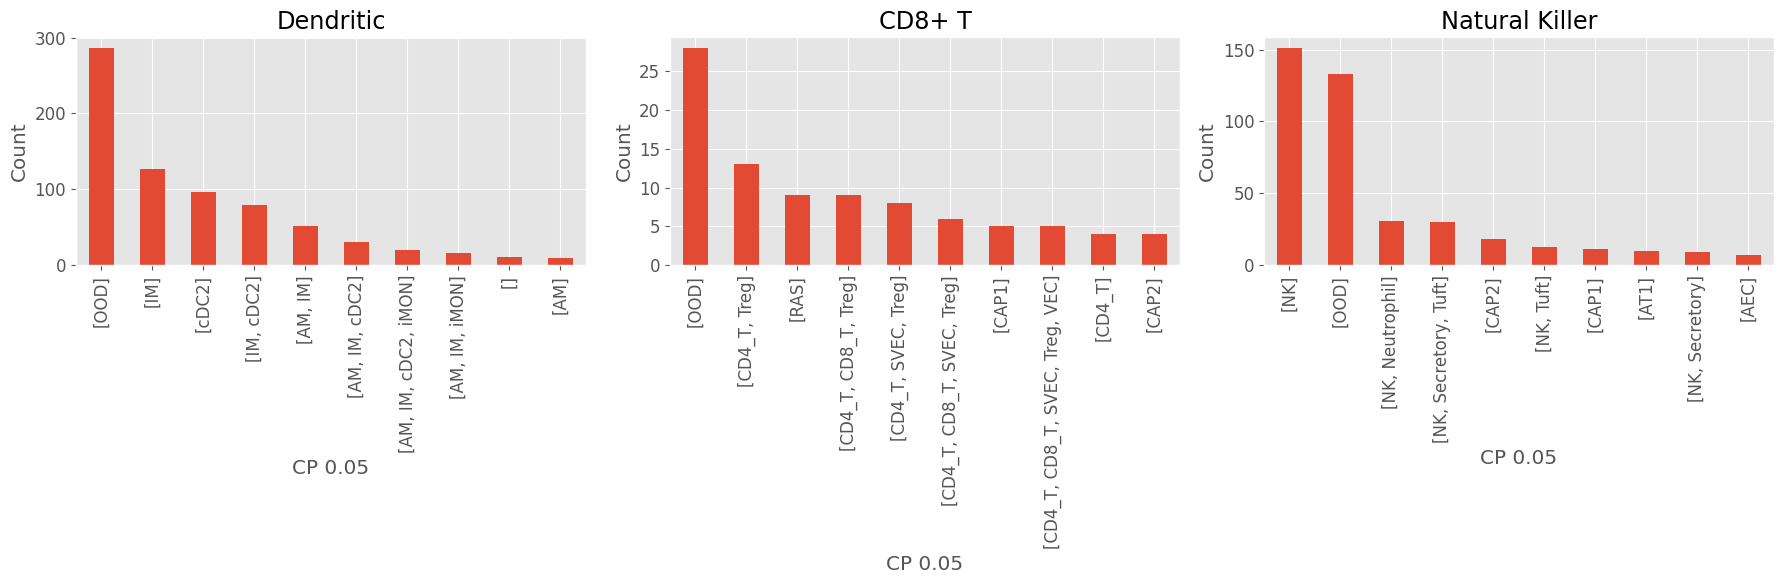

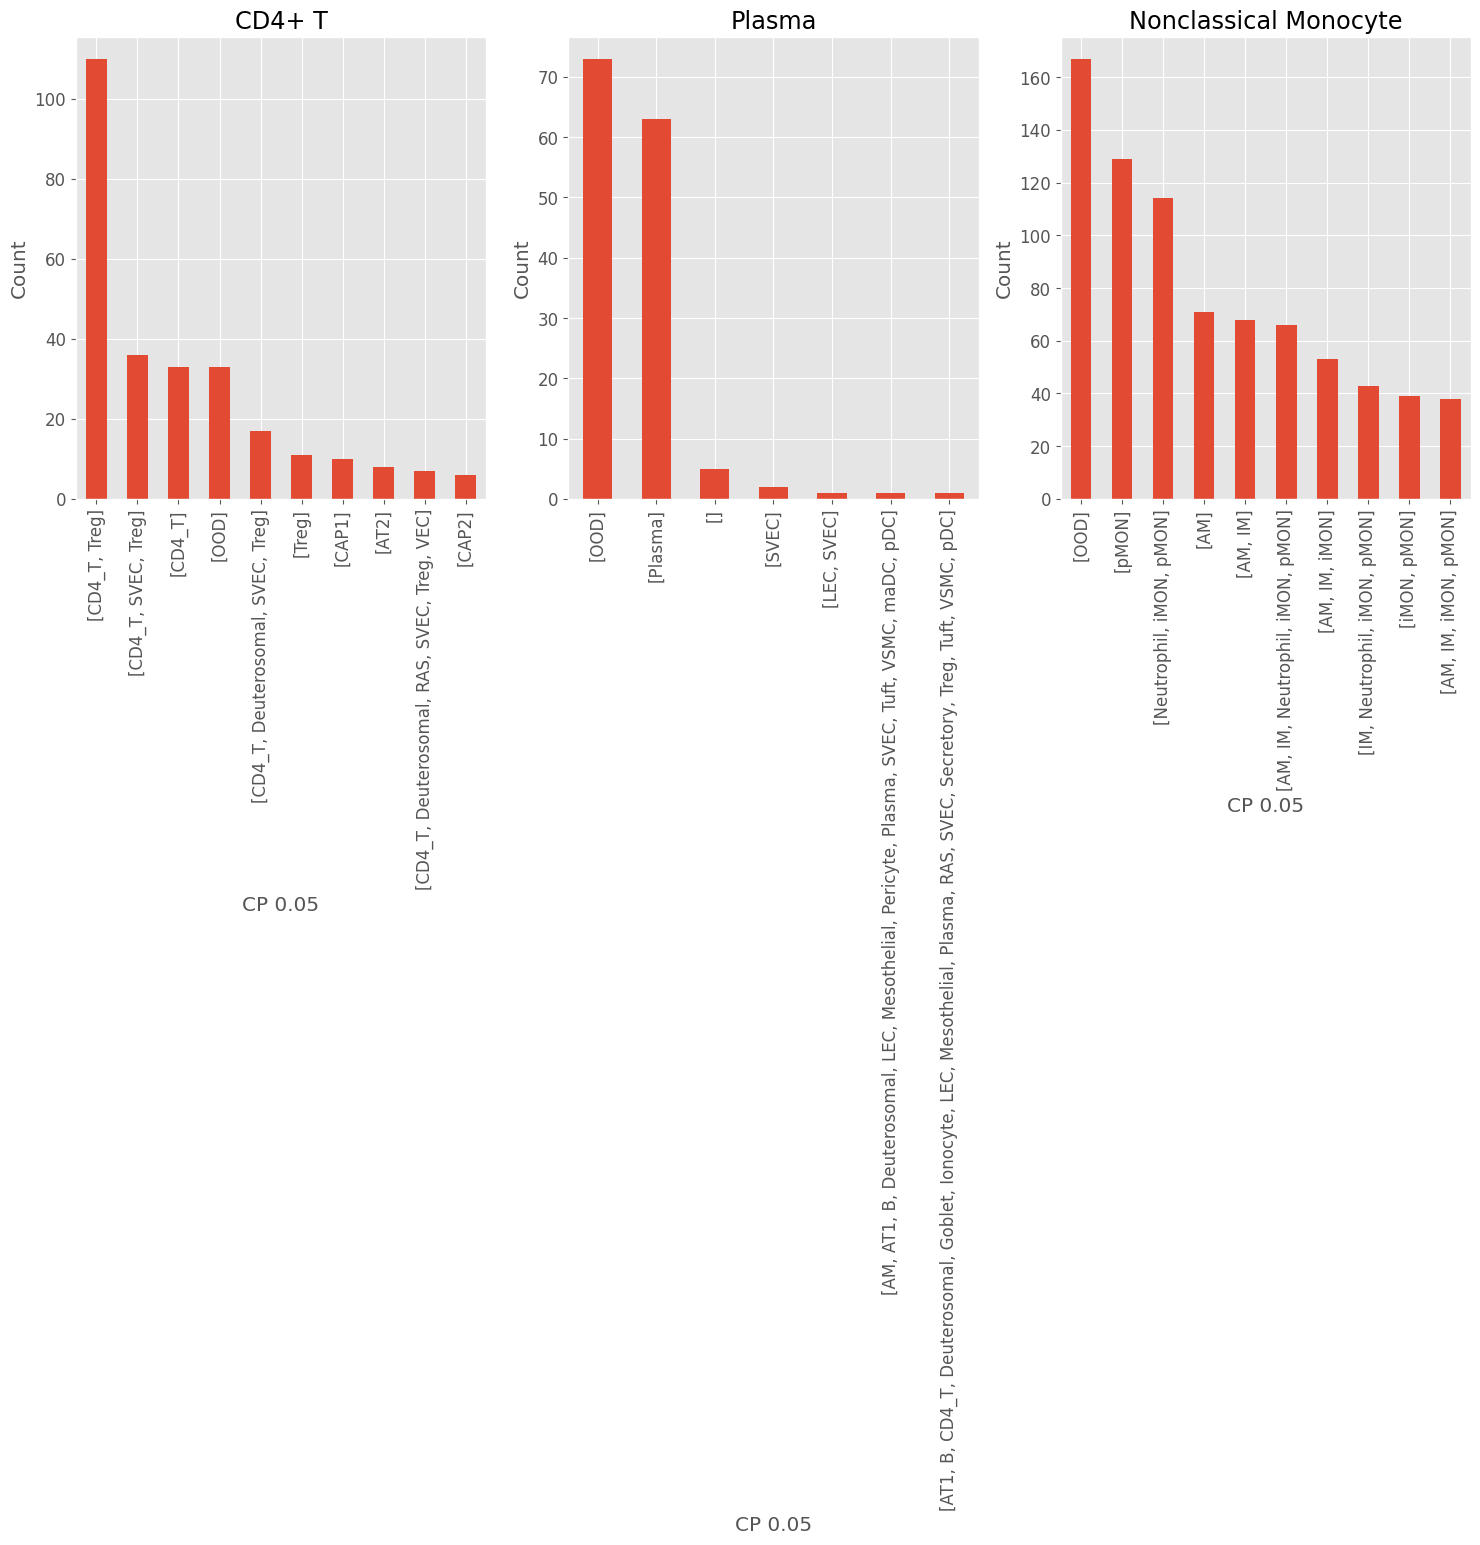

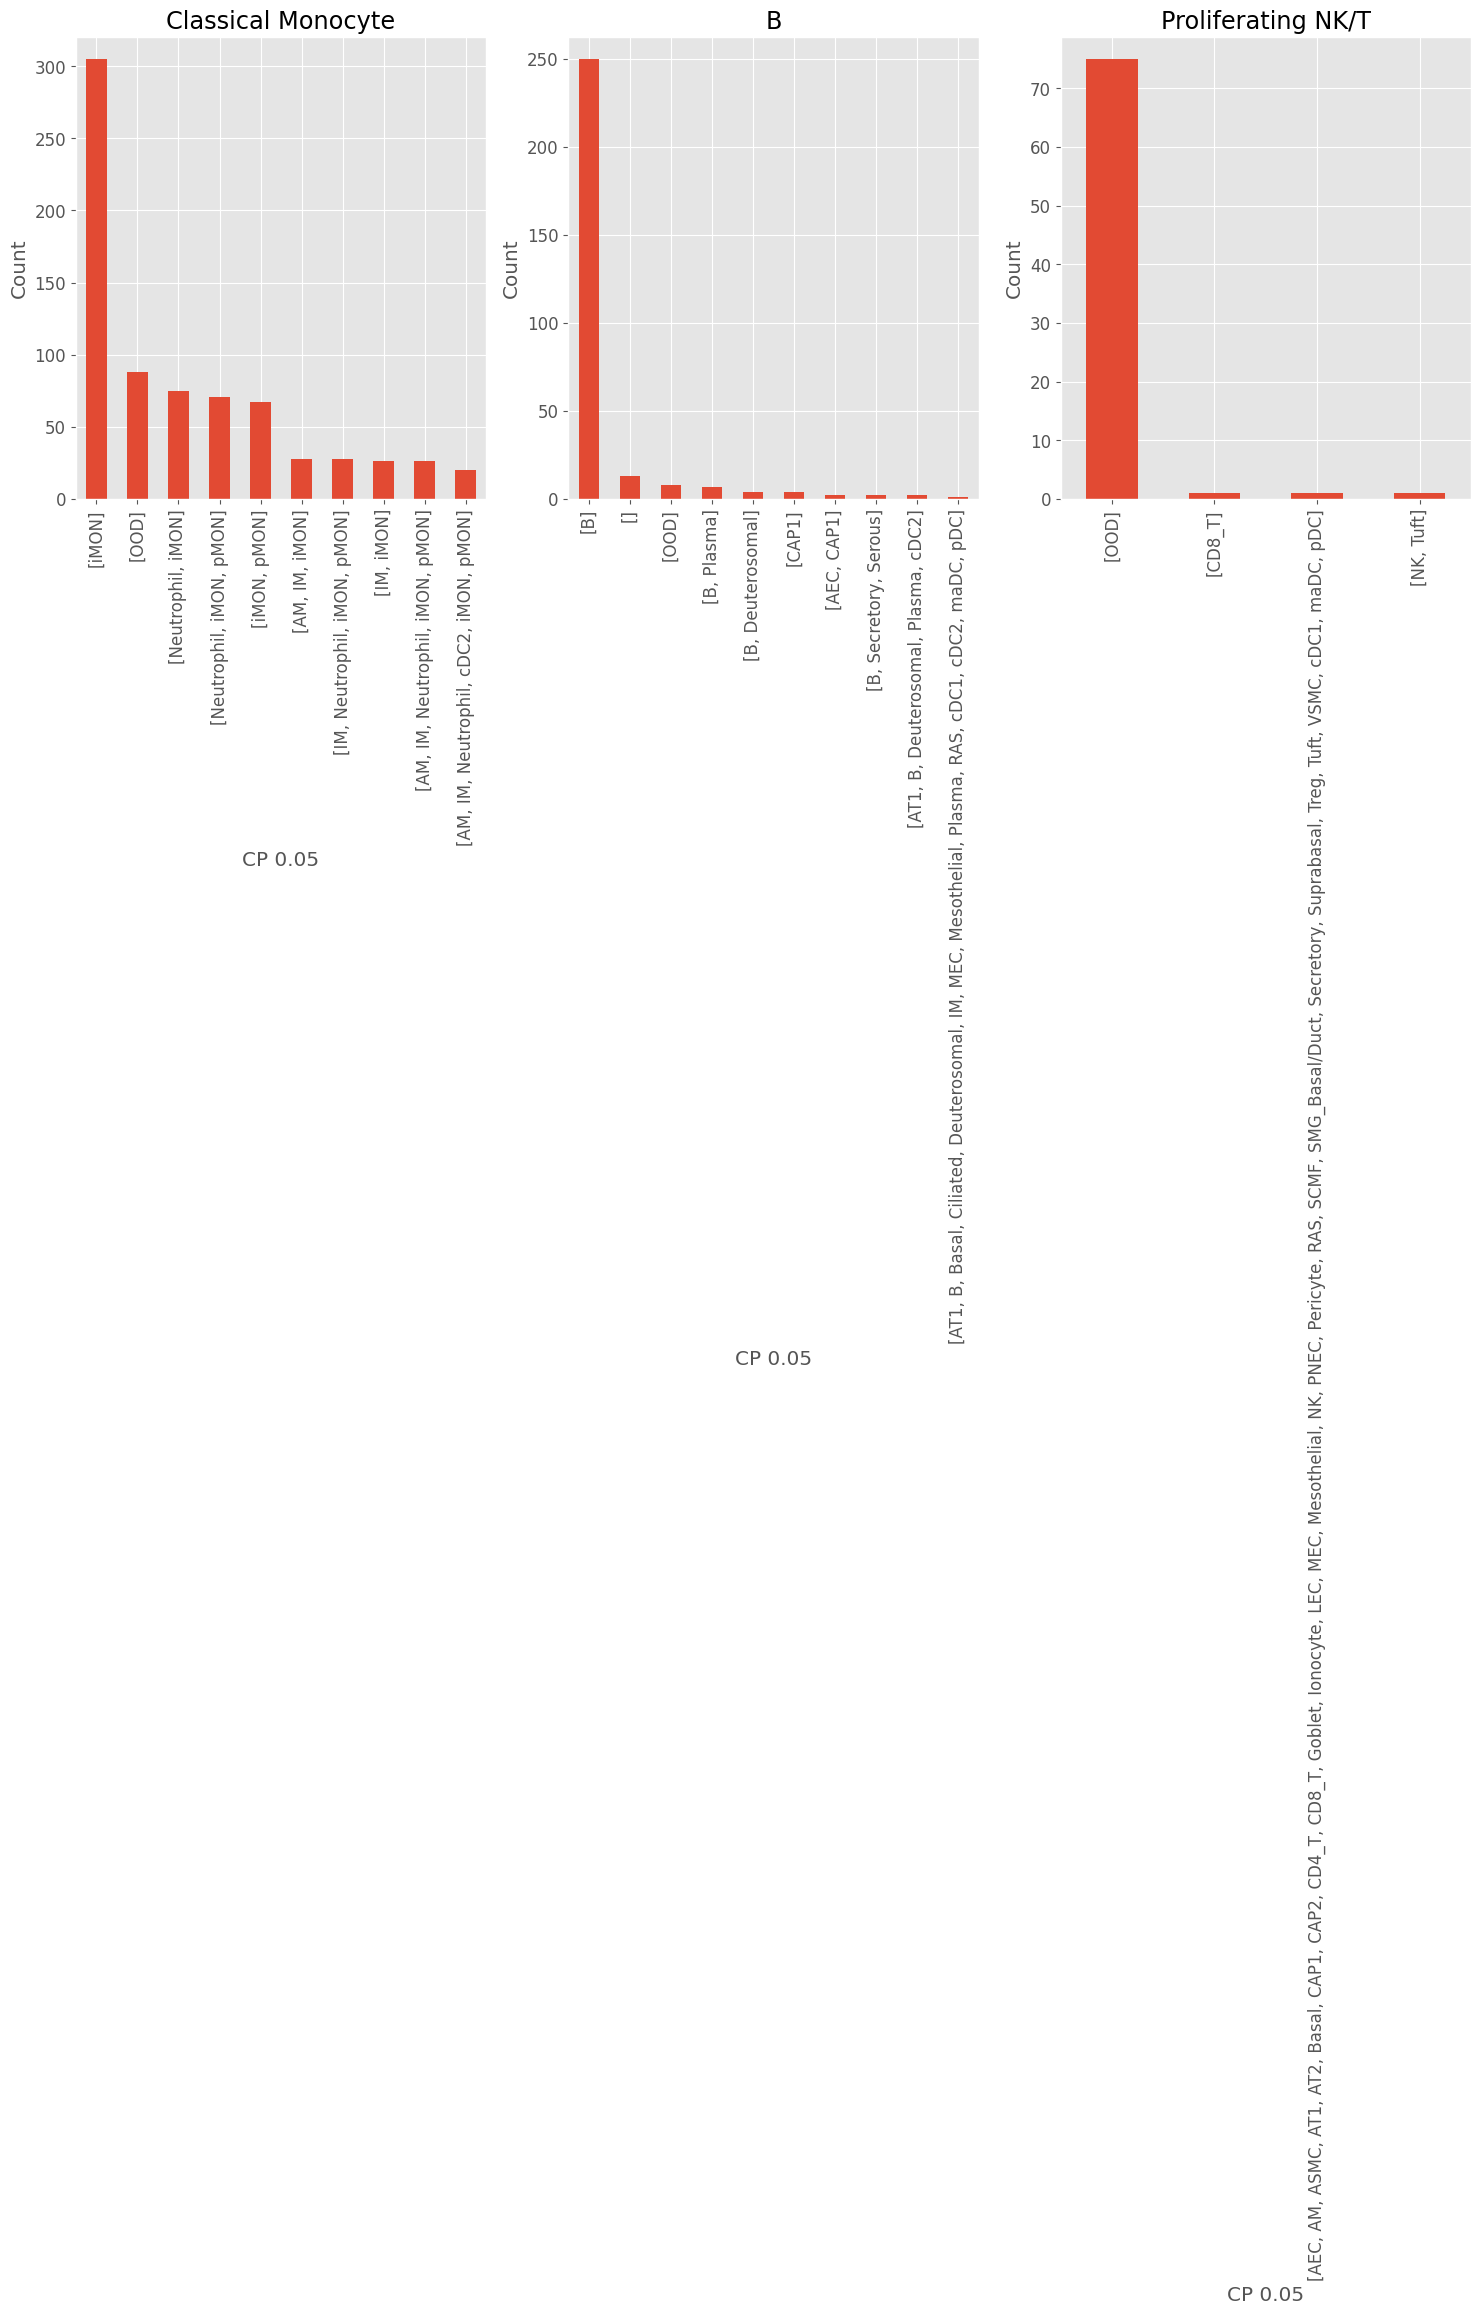

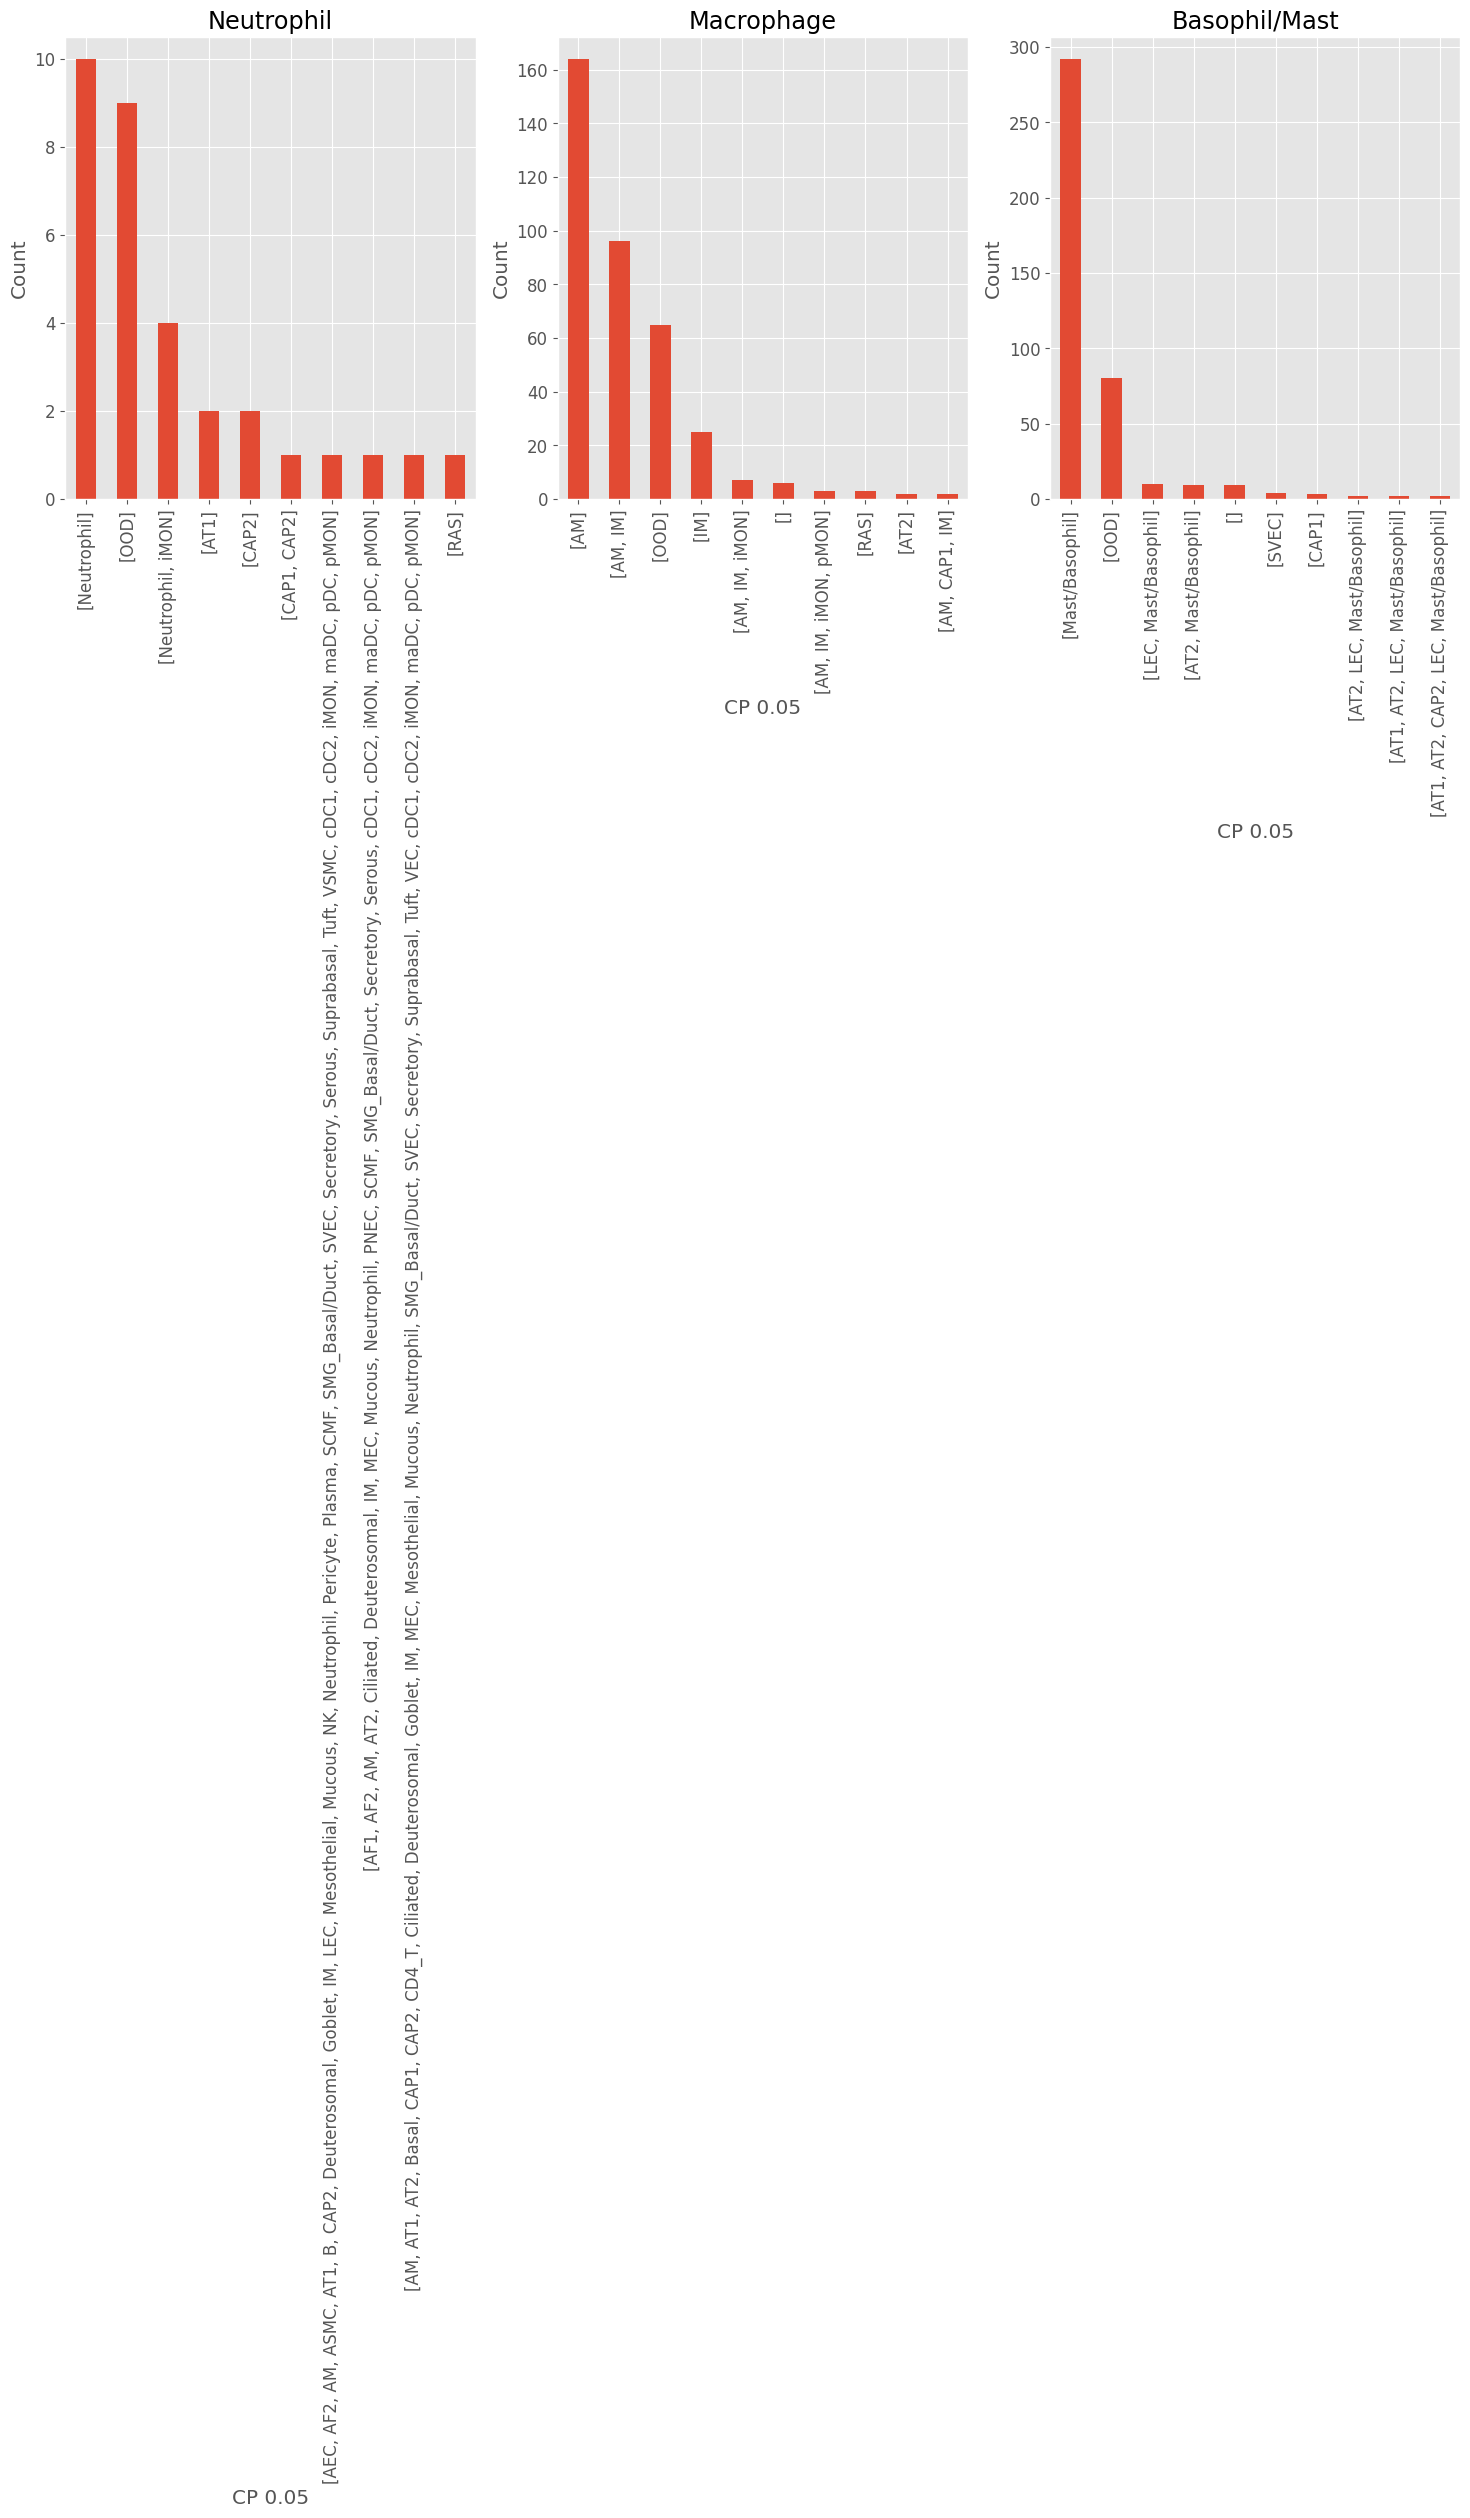

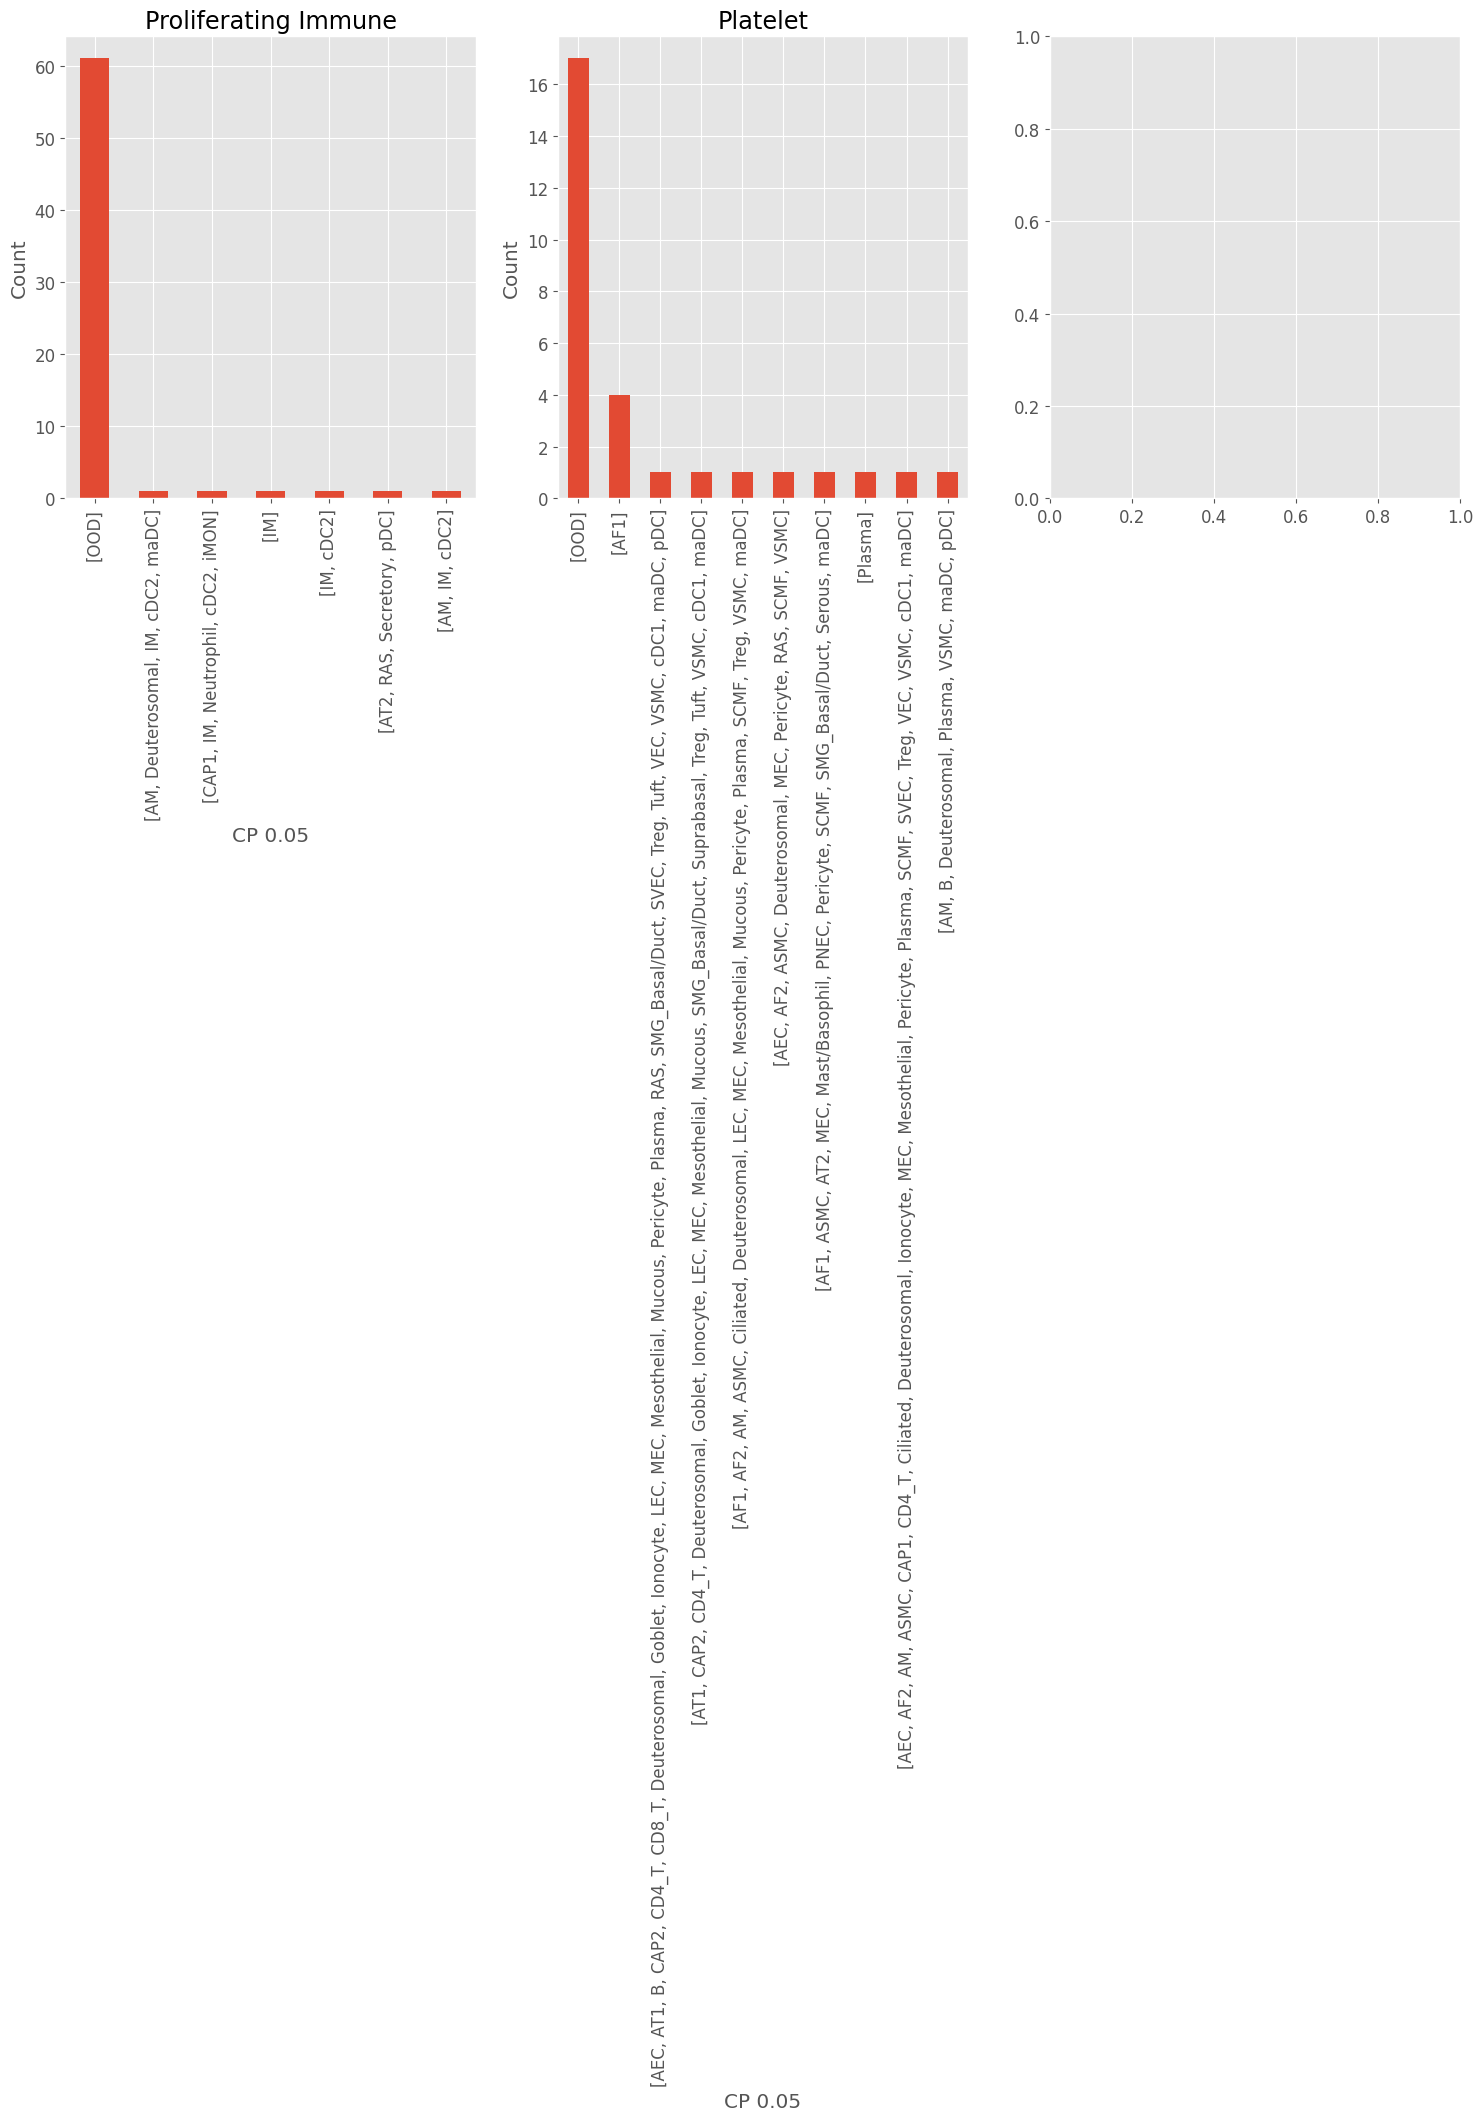

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set scientific style
plt.style.use('ggplot')
rcParams.update({'font.size': 12, 'figure.figsize': (12, 6)})

unique_cells = df_results['Original_Cell_Subtype'].unique()

# Create blocks of 3
block_size = 3
for i in range(0, len(unique_cells), block_size):
    fig, axes = plt.subplots(1, block_size, figsize=(18, 6))
    for j, cell in enumerate(unique_cells[i:i + block_size]):
        ax = axes[j] if block_size > 1 else axes
        df_ = df_results[df_results['Original_Cell_Subtype'] == cell]
        
        # Get the value counts and limit to the top 10 elements
        value_counts = df_["CP 0.05"].value_counts().head(10)
        
        # Plot on the corresponding subplot
        value_counts.plot(kind='bar', ax=ax)
        ax.set_title(cell)
        ax.set_xlabel('CP 0.05')
        ax.set_ylabel('Count')
        
    
    # Adjust layout
    plt.tight_layout()
    plt.show()